Импортируем нужные библиотеки и подготавливаем датасет

In [347]:
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import csv
%matplotlib inline

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as ss

from collections import Counter
import math

In [348]:
df = pd.read_csv("dogs2017.csv")
df.head()

,LicenseType,Breed,Color,DogName,OwnerZip,ExpYear,ValidDate
0,Dog Individual Spayed Female,BICHON FRISE,WHITE,CHLOE,15090,2017,12/15/2016 9:58
1,Dog Senior Citizen or Disability Spayed Female,CHIHUAHUA,WHITE/BLACK/BROWN,CHALUPA,15120,2017,3/23/2017 14:32
2,Dog Individual Spayed Female,LAB MIX,YELLOW,MIA,15133,2017,2/28/2017 10:59
3,Dog Individual Male,DACHSHUND,BLACK/BROWN/GREY,CODY,15108,2017,2/9/2017 13:40
4,Dog Individual Spayed Female,DACHSHUND,BLACK,SOPHIE,15108,2017,2/9/2017 13:40


In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21727 entries, 0 to 21726
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LicenseType  21727 non-null  object
 1   Breed        21727 non-null  object
 2   Color        21727 non-null  object
 3   DogName      21727 non-null  object
 4   OwnerZip     21727 non-null  int64 
 5   ExpYear      21727 non-null  int64 
 6   ValidDate    21527 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.2+ MB


В этот раз датасет собак. Будем определять пол собаки по ее имени, породе и цвету. Нам нужно представить как-то имя через другие величины. Я придумал отображать номер первой и второй букв сначала и с конца имени, а также длину имени. Создаю новые колонки, удаляю ненужные, величины которых не представлены в виде чисел, и мы не можем работать с ними.

In [350]:
def checkGend(stri, stri2):
    if stri2 in stri:
        return "F"
    else:
        return "M"
    
print(ord('A') - 64)
    
    
df["Gender"] = "F"
df["firstDigID"] = 0
df["secondDigID"] = 0
df["lastDigID"] = 0
df["predlastDigID"] = 0
df["digits"] = 0
df["BreedID"] = 0
df["ColorID"] = 0


breeds = []
colors = []

for i in range(df["Gender"].size):
    df.at[i,"Gender"] = checkGend(df["LicenseType"][i], "Female")
    df.at[i,"firstDigID"] = float(min(26,max(0, ord((df["DogName"][i][0]).upper()) - 64)))
    df.at[i,"secondDigID"] = float(min(26,max(0, ord((df["DogName"][i][min(1, len(df["DogName"][i]) - 1)]).upper()) - 64)))
    df.at[i,"lastDigID"] = float(min(26,max(0, ord((df["DogName"][i][len(df["DogName"][i]) - 1]).upper()) - 64)))
    df.at[i,"predlastDigID"] = float(min(26,max(0, ord((df["DogName"][i][len(df["DogName"][i]) - 2]).upper()) - 64)))
    df.at[i,"digits"] = float(len(df["DogName"][i]))
    if (df["Breed"][i] in breeds):
        df.at[i,"BreedID"] = float(breeds.index(df["Breed"][i]))
    else:
        breeds.append(df["Breed"][i])
        df.at[i,"BreedID"] = float(len(breeds) - 1)
        
    if (df["Color"][i] in colors):
        df.at[i,"ColorID"] = float(colors.index(df["Color"][i]))
    else:
        colors.append(df["Color"][i])
        df.at[i,"ColorID"] = float(len(colors) - 1)



drop_list = ['LicenseType', 'OwnerZip', 'ExpYear', 'ValidDate', 'Breed', 'Color']
df.drop(drop_list, axis=1, inplace=True)
    



1


In [351]:
df

,DogName,Gender,firstDigID,secondDigID,lastDigID,predlastDigID,digits,BreedID,ColorID
0,CHLOE,F,3,8,5,15,5,0,0
1,CHALUPA,F,3,8,1,16,7,1,1
2,MIA,F,13,9,1,9,3,2,2
3,CODY,M,3,15,25,4,4,3,3
4,SOPHIE,F,19,15,5,9,6,3,4
...,...,...,...,...,...,...,...,...,...
21722,RUBY,F,18,21,25,2,4,38,14
21723,STELLALUNA,F,19,20,1,14,10,11,12
21724,JAXXON,M,10,1,14,15,6,7,4
21725,BONNIE,F,2,15,5,9,6,5,7


In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21727 entries, 0 to 21726
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DogName        21727 non-null  object
 1   Gender         21727 non-null  object
 2   firstDigID     21727 non-null  int64 
 3   secondDigID    21727 non-null  int64 
 4   lastDigID      21727 non-null  int64 
 5   predlastDigID  21727 non-null  int64 
 6   digits         21727 non-null  int64 
 7   BreedID        21727 non-null  int64 
 8   ColorID        21727 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.5+ MB


Пишем функции для работы с хитмапами

In [353]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def apply(df, f):
    n = df.shape[1]
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mat[i][j] = f(df[df.columns[i]], df[df.columns[j]])
    ndf = pd.DataFrame(mat, index=df.columns, columns=df.columns)
    return ndf

Вот они, наши хитмапы! Имя все же сильнее всего влияет на пол. Оно и не удивительно. Но как мы можем заметить, именно в имени больше всего на пол влияет последняя буква имени. Затем уже предпоследняя буква, потом первая, вторая, а затем уже длина имени. Судя по данному хитмапу, мы видим, что пол собаки почти не зависит от ее породы и цвета.

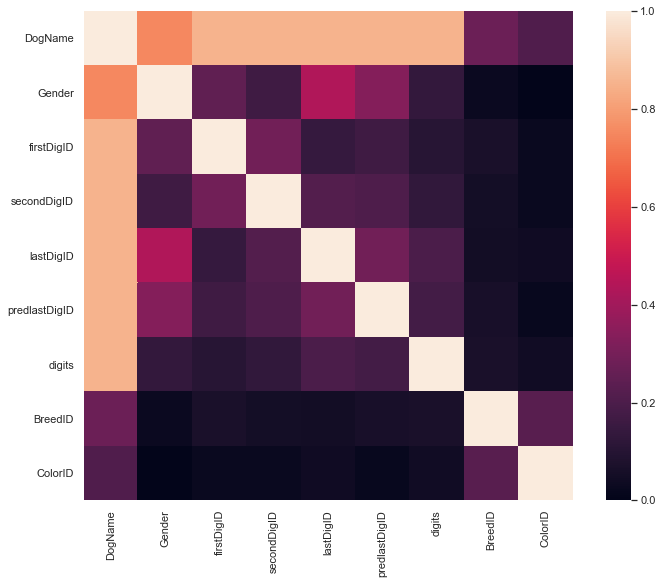

In [354]:
cramers_v_mat = apply(df, cramers_v)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cramers_v_mat, vmax=1.0, square=True);

In [355]:
row = cramers_v_mat.iloc[1]
row.sort_values(axis='index', ascending=False)

Gender           0.999908
DogName          0.752369
lastDigID        0.436463
predlastDigID    0.333816
firstDigID       0.248513
secondDigID      0.167643
digits           0.134562
BreedID          0.027926
ColorID          0.000000
Name: Gender, dtype: float64

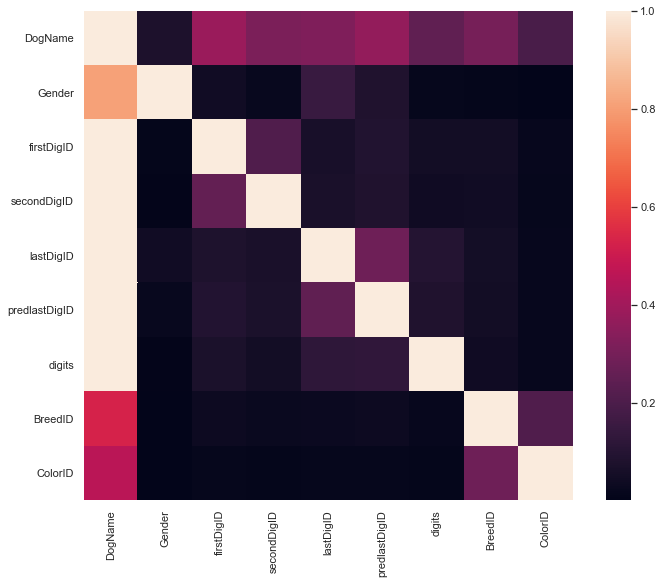

In [356]:
theils_u_mat = apply(df, theils_u)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(theils_u_mat, vmax=1.0, square=True);

Отсортируем зависимость гендера собаки от ее характеристик. Создаем новую базу данных, где имеются только численные значения. С другими мы не можем пока работать. Также строим графики.

In [357]:
row = theils_u_mat.iloc[1]
row.sort_values(axis='index', ascending=False)

Gender           1.000000
DogName          0.812564
lastDigID        0.152133
predlastDigID    0.084857
firstDigID       0.046612
secondDigID      0.022367
digits           0.014347
BreedID          0.010369
ColorID          0.002423
Name: Gender, dtype: float64

In [358]:
df_nums = df.select_dtypes([np.number])
df_nums = pd.concat([df['Gender'].map({'F' : 0, 'M' : 1}), df_nums], axis=1)
df_nums

,Gender,firstDigID,secondDigID,lastDigID,predlastDigID,digits,BreedID,ColorID
0,0,3,8,5,15,5,0,0
1,0,3,8,1,16,7,1,1
2,0,13,9,1,9,3,2,2
3,1,3,15,25,4,4,3,3
4,0,19,15,5,9,6,3,4
...,...,...,...,...,...,...,...,...
21722,0,18,21,25,2,4,38,14
21723,0,19,20,1,14,10,11,12
21724,1,10,1,14,15,6,7,4
21725,0,2,15,5,9,6,5,7


Получилось много-много графиков. В первой колонке видно, сколько собак с определенными буквами в начале/конце имени, и т д - женского пола, а сколько - мужского

<Figure size 1800x720 with 0 Axes>

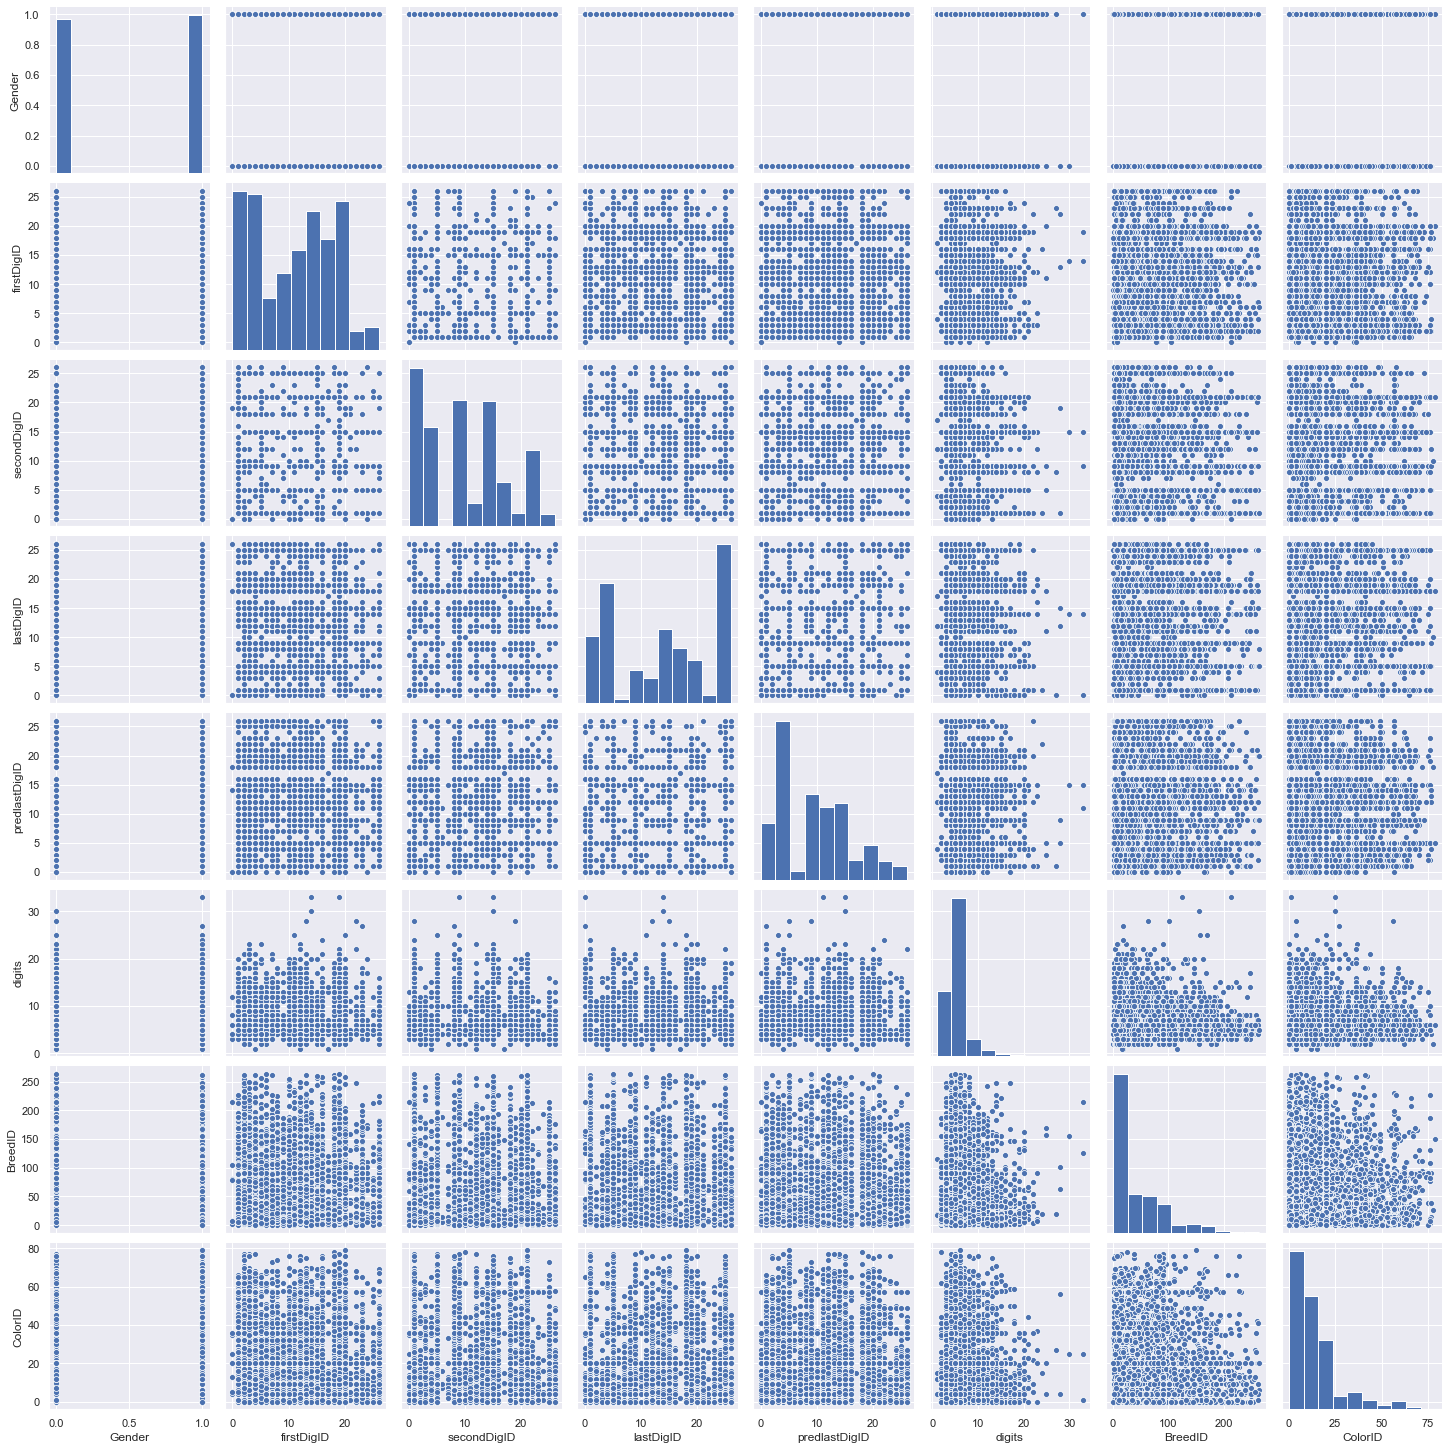

In [359]:
plt.figure(figsize=(25,10))

cols = ['Gender', 'firstDigID', 'secondDigID', 'lastDigID', 'predlastDigID',
       'digits', 'BreedID', 'ColorID']
sns.pairplot(df_nums[cols])
plt.show()

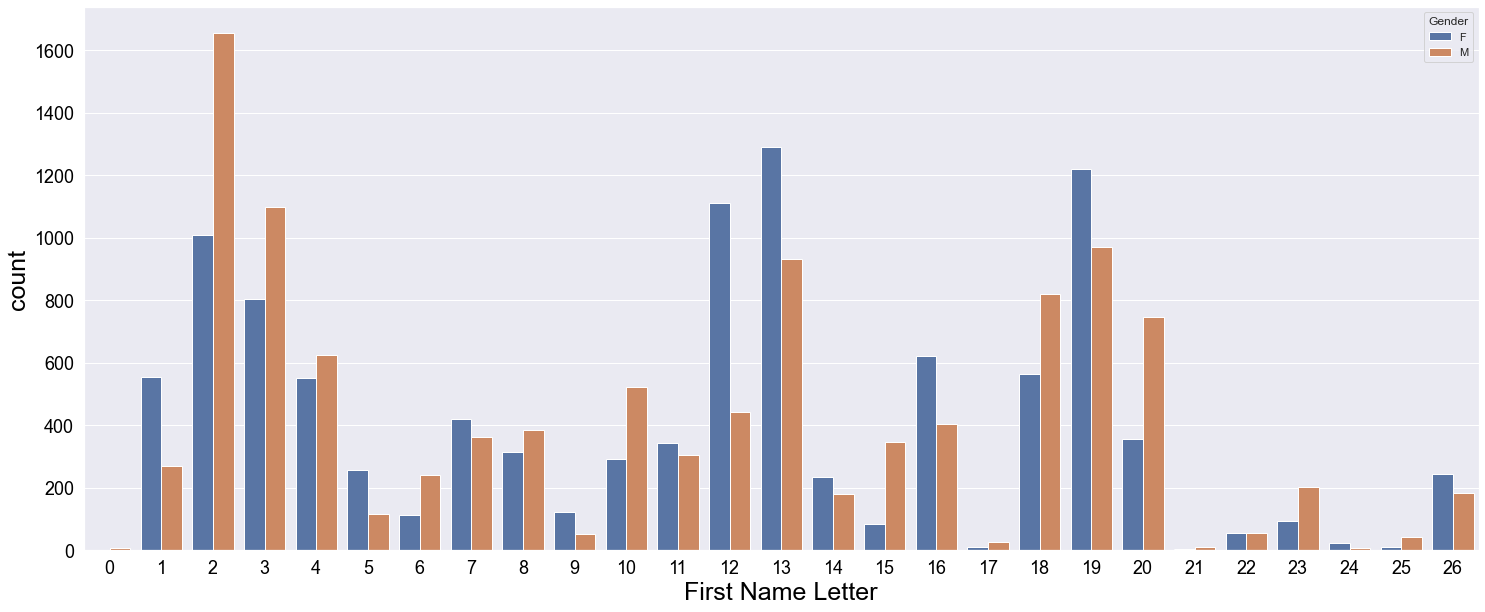

In [360]:
plt.figure(figsize=(25,10))
ax=sns.countplot(x='firstDigID',hue='Gender',data=df)

plt.xlabel("First Name Letter", color='black', size=25)
plt.ylabel("count", color='black', size=25)
plt.xticks(color='black', size=18)
plt.yticks(color='black', size=18)

plt.show()

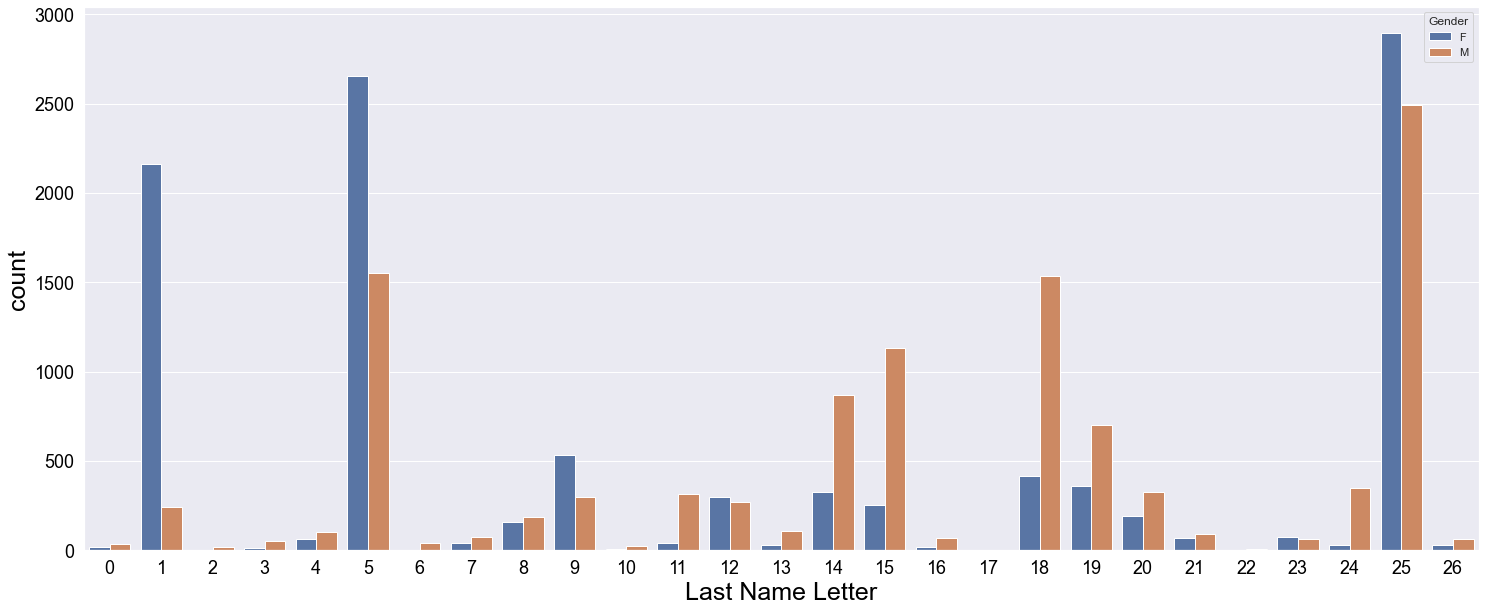

In [361]:
plt.figure(figsize=(25,10))
ax=sns.countplot(x='lastDigID',hue='Gender',data=df)

plt.xlabel("Last Name Letter", color='black', size=25)
plt.ylabel("count", color='black', size=25)
plt.xticks(color='black', size=18)
plt.yticks(color='black', size=18)

plt.show()

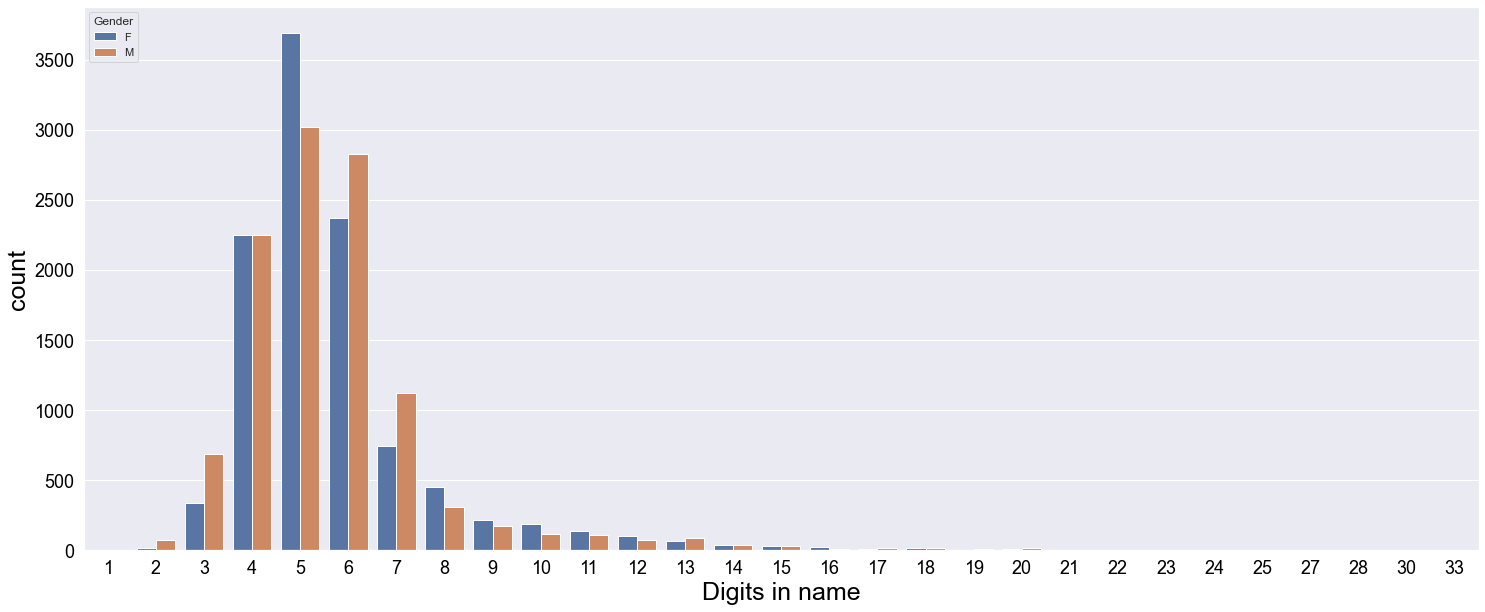

In [362]:
plt.figure(figsize=(25,10))
ax=sns.countplot(x='digits',hue='Gender',data=df)

plt.xlabel("Digits in name", color='black', size=25)
plt.ylabel("count", color='black', size=25)
plt.xticks(color='black', size=18)
plt.yticks(color='black', size=18)

plt.show()

Мы разобрались с данными. Теперь можно и приступить реализовывать саму нейросеть и обучение!  
Возьмем только самые важные параметры для обучения, которые влияют на пол больше всего.  

Пол принимает только два значения, поэтому, сейчас нам не придется заморачиваться с категориями и можем использовать алгоритмы сразу в первоначальном виде.

In [380]:
#Лабораторная 2 - уже будем делать саму нейросеть и обучать модели

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

best_cols = ['firstDigID', 'secondDigID', 'lastDigID', 'predlastDigID', 'digits', 'BreedID', 'ColorID']

x = pd.get_dummies(df_nums[best_cols])


y = df_nums['Gender'].to_numpy()


MinMax = MinMaxScaler()

x = MinMax.fit_transform(x.to_numpy()) 



[0.46153846 0.80769231 0.19230769 0.42307692 0.09375    0.02651515
 0.05063291]


In [366]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn import linear_model

from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import check_random_state

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Логистическая регрессия
Проходим всего один раз, тк категория бинарная.

In [388]:
class LogRegression():
    
    def __init__(self):
        self.lr = 1
        self.iters = 1024
        
    def add_ones(self, x):
        return np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, x, y):
        
        x = self.add_ones(x)
        self.w = np.zeros(x.shape[1]) #веса
        
        for i in range(self.iters):
            h = self.sigmoid(np.dot(x, self.w))
            grad = np.dot(x.T, (h - y)) / y.size
            self.w -= self.lr * grad
    
    def predict(self, x):
        x = self.add_ones(x)
        xW = np.dot(x, self.w)
        return self.sigmoid(xW) >= 0.5
    
    def predictCW(self, x, ws):
        x = self.add_ones(x)
        xW = np.dot(x, ws)
        return self.sigmoid(xW) >= 0.5

In [391]:



def print_res(clf, X, y, typ='noFlag', k_folds=5, average='macro'):
    
    kf = StratifiedKFold(n_splits=k_folds, random_state=256, shuffle=True)
    precision = np.zeros(k_folds) 
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        # numpy required in case of algos realisation
        X_train = X[train_index]
        y_train = y[train_index]

        X_val, y_val = X[val_index], y[val_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        
        if (typ == "logR"):
            ws = clf.w
            
        
        precision[i] = precision_score(y_val, y_pred, average=average)
        
    if (typ == "logR"):
        return precision, ws
    else:
        return precision




В предсказании пола работает довольно плохо. 60% угадать пол, что близко к 50%, если мы просто выберем случайное число. Плохо работает не только наша реализация, но и библиотечная. Похоже, этот метод не подходит для данной задачи.

In [392]:

mulLR = linear_model.LogisticRegression(solver='newton-cg').fit(x, y)
ansPrec = print_res(mulLR, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansPrec.mean(), ansPrec.std() * 2))


mulLRmy = LogRegression()
ansPrec2 = print_res(mulLRmy, x, y, "logR")
print("Precision score: %0.5f (+/- %0.5f)" % (ansPrec2[0].mean(), ansPrec2[0].std() * 2))

Precision score: 0.60030 (+/- 0.01308)
Precision score: 0.60026 (+/- 0.01329)


 Можно придумать и свои примеры, и посмотреть, как нейросеть определит пол.

In [393]:
#Придумаем свои примеры
with open('myDogDB.csv', 'w') as myfile:
    wr = csv.writer(myfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    wr.writerow(['firstDigID', 'secondDigID', 'lastDigID', 'predlastDigID', 'digits', 'BreedID', 'ColorID'])
    wr.writerow([19, 15, 5, 9, 6, 3, 4]) #Sophie
    wr.writerow([1, 14, 5, 9, 5, 7, 1]) #Annie
    wr.writerow([22, 12, 4, 1, 4, 6, 8]) #Vlad
    wr.writerow([4, 9, 14, 1, 5, 5, 5]) #Diman
    wr.writerow([19, 8, 1, 8, 7, 1, 3]) #Shavuha
    wr.writerow([25, 22, 25, 13, 5, 4, 8]) #Yummy
    wr.writerow([5, 4, 1, 4, 3, 7, 6]) #Eda
    wr.writerow([19, 8, 1, 13, 8, 6, 9]) #Shaverma
    wr.writerow([4, 15, 7, 7, 4, 52, 14]) #Dogg
    wr.writerow([2, 15, 2, 15, 3, 48, 41]) #Bob
    wr.writerow([16, 5, 18, 5, 5, 33, 61]) #Peter
    wr.writerow([9, 22, 14, 1, 4, 117, 11]) #Ivan
    wr.writerow([12, 21, 5, 11, 4, 6, 8]) #Luke
    wr.writerow([1, 1, 1, 1, 1, 1, 1]) #A
    wr.writerow([26, 26, 26, 26, 33, 260, 80]) #Zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
    
myDF = pd.read_csv("myDogDB.csv").drop_duplicates()   

best_cols = ['firstDigID', 'secondDigID', 'lastDigID', 'predlastDigID', 'digits', 'BreedID', 'ColorID']

xNew = pd.get_dummies(myDF[best_cols])

MinMax = MinMaxScaler()

xNew = MinMax.fit_transform(xNew.to_numpy()) 
print(xNew[12])

[0.44       0.8        0.16       0.4        0.09375    0.01930502
 0.08860759]


Нейросети удалось угадать даже пол некоторых собак, которых я придумал. Однако, некоторые чисто мужские именя (Vlad, Bob, Luke она определила как женские)

In [400]:
print("Genders:")

clf = LogRegression()

ws = ansPrec2[1]

y_pred = clf.predictCW(xNew, ws)
y_ans = []


for i in range(y_pred.size):
    if (y_pred[i]):
        y_ans.append("Male")
    else:
        y_ans.append("Female")
        
print(y_ans)



Genders:
['Female', 'Female', 'Female', 'Male', 'Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Male', 'Male', 'Female', 'Female', 'Male']


# K ближайших соседей


In [403]:
class KNN():
    def __init__(self, nbrs=10):
        self.nbrs = nbrs
    
    def fit(self, x, y):
        self.x = x
        self.y = y.reshape((y.shape[0], 1))

    def get_dists(self, p):
        d = self.x - p
        return np.sqrt((d**2).sum(1))

    def predict(self, X):
        n = X.shape[0]
        y_pred = np.zeros((n, 1))
        for i in range(n):
            dist = self.get_dists(X[i])
            
            y_sort = self.y[np.argsort(dist)].flatten()

            if y_sort[:self.nbrs].sum() > self.nbrs / 2:
                y_pred[i] = 1.0
        
        return y_pred

In [404]:


KNNnotMy = KNeighborsClassifier(n_neighbors=5).fit(x, y)
ansKNN = print_res(KNNnotMy, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansKNN.mean(), ansKNN.std() * 2))


KNNmy = KNN(nbrs=5)
ansKNN2 = print_res(KNNmy, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansKNN2.mean(), ansKNN2.std() * 2))


Precision score: 0.78005 (+/- 0.00853)
Precision score: 0.77954 (+/- 0.00974)


Вау, почти 80% для такого простого метода. Учитывая то, что предсказать пол собаки довольно трудно по таким данным - это вполне хороший результат. Метод KNN лучше подходит и не слишком сложен в реализации. Может почти с 80% вероятностью отгадать пол собаки.

# Метод опорных векторов  

In [407]:
class SVM:
    def __init__(self, alpha=0.001, eta=0.1, eps=0.0001, ticks=50):
        self.ticks = ticks
        self.eta = eta
        self.alpha = alpha
        self.eps = eps
        self.prLoss = float('inf')
    
    def fit(self, X, y, verbose=False):
        X = self.extend(np.array(X))
        y = np.array(y)
        
        for i in range(len(y)):
            if y[i] == 0.0:
                y[i] = -1.0

        self.w = np.random.normal(size=X.shape[1])
        
        ticks = 0
        while True:
            loss = 0
            for i, x in enumerate(X):
                margin = y[i] * np.dot(self.w, x)
                if margin >= 1:
                    self.w = self.w - self.eta * self.alpha * self.w / self.ticks
                else:
                    self.w = self.w + self.eta * (y[i] * x - self.alpha * self.w / self.ticks)
                loss += self.soft_margin_loss(x, y[i])
            if ticks == self.ticks or abs(self.prLoss - loss) <= self.eps:
                return
            
            self.prLoss = loss
            ticks += 1
            
    def predict(self, X):
        X_ext = self.extend(np.array(X))
        return np.array([np.sign(np.dot(self.w, x)) == 1 for x in X_ext]) 
    
    def extend(self, x):
        x_extended = np.zeros((x.shape[0], x.shape[1] + 1))
        x_extended[:,:-1] = x
        x_extended[:,-1] = int(1)  
        return x_extended
    
    def hinge_loss(self, x, y):
        return max(0, 1 - y * np.dot(x, self.w))
    
    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x, y) + self.alpha * np.dot(self.w, self.w) / 2

In [408]:
SVMnm = SVC(kernel='linear').fit(x, y)
ansSVM = print_res(SVMnm, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansSVM.mean(), ansSVM.std() * 2))



SVMmy = SVM()
ansSVM2 = print_res(SVMmy, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansSVM2.mean(), ansSVM2.std() * 2))

Precision score: 0.61737 (+/- 0.00821)
Precision score: 0.60041 (+/- 0.08382)


Сработал так же плохо, как и метод логистической регрессии. Только этот метод еще более сложный и громоздкий. Как мы видим, библиотечная реализация тоже плохо работает, а это значит, что при таком объеме данных нам этот метод не подходит.

# Метод дерева решений  

In [409]:
class Node():
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


class DecisionTree():
    def __init__(self, max_depth=20, rf=False):
        self.max_depth = max_depth
        self.feature_prun = 0.1
        self.rf = rf

    def fit(self, X, y, max_features=None):
        self.n_classes_ = len(set(y))
        if not self.rf:
            n_features_ = X.shape[1]
        else:
            ind = np.random.choice(X.shape[0], X.shape[0])
            X, y = X[tuple([ind])], y[tuple([ind])]
            if max_features is None:
                n_features_ = np.ceil(np.sqrt(X.shape[1]*4)).astype(int)
            else:
                n_features_ = max_features
                
        self.features_ = np.sort(np.random.choice(X.shape[1], n_features_,
                                                  replace=False))
        self.tree_ = self._grow_tree(X, y, self.rf)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _best_split(self, X, y, rf):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in self.features_:
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, rf, depth=0):
        num_samples_per_class = [np.sum(y == i)
                                 for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y, rf)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, rf, depth + 1)
                node.right = self._grow_tree(X_right, y_right, rf, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [410]:
DTreenm = DecisionTreeClassifier().fit(x, y)
ansDTree = print_res(DTreenm, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansDTree.mean(), ansDTree.std() * 2))


DTreemy = DecisionTree()
ansDTree2 = print_res(DTreemy, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansDTree2.mean(), ansDTree2.std() * 2))

Precision score: 0.81340 (+/- 0.01700)
Precision score: 0.81752 (+/- 0.01555)


Результаты даже лучше, чем у метода соседей, но при этом на таких данных наша программа уже начинает работать довольно медленно. Так, что, если производительность важнее точности, лучше использовать метод соседей.

# Метод рандомного леса  

In [411]:
class RandomForest():
    def __init__(self, max_depth=15, n_ests=20, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_ests = n_ests
        self.forest = [None] * n_ests

    def fit(self, X, y):
        for i in range(self.n_ests):
            self.forest[i] = DecisionTree(max_depth=self.max_depth, rf=True) 
            self.forest[i].fit(X, y)

    def predict(self, X):
        most_cmn = np.zeros(X.shape[0])
        preds = np.zeros((self.n_ests, X.shape[0]))
        for i in range(self.n_ests):
            preds[i] = self.forest[i].predict(X)
        for i in range(len(most_cmn)):
            most_cmn[i] = Counter(preds[:, i]).most_common(1)[0][0]
        return most_cmn

In [412]:
rfLib = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=0).fit(x, y)
ansRF = print_res(rfLib, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansRF.mean(), ansRF.std() * 2))


rfMy = RandomForest(max_depth=20, n_ests=10)
ansRF2 = print_res(rfMy, x, y)
print("Precision score: %0.5f (+/- %0.5f)" % (ansRF2.mean(), ansRF2.std() * 2))

Precision score: 0.83783 (+/- 0.00984)
Precision score: 0.83842 (+/- 0.00799)


Снова же оказался лучшим методом, показав почти 84% шанс угадать пол. Однако, программа работала очень долго, наверное, из-за больших данных, но это не точно. При этом, метод KNN не намного хуже, но намного проще и быстрее.

# Вывод:  
Для данной задачи снова самым эффективным оказался метод леса. Он является самым продвинутым и трудным в реализации, потому что повторяет несколько раз сложный метод дерева решений. Как мы видим, метода соседей показал себя тоже довольно хорошо в данной задаче, а методы логистической регрессии и векторов показали хуже всего. В прошлой же задаче лучше всего оказалась программная реализация логистической регрессии. Еще раз это подтверждает, что для каждой задачи самыми эффективными алгоритмами могут оказаться разные. Но случайный лес все равно держит первые позиции.